In [1]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from ironpy.analytics import DB
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pickle
from airflow.providers.postgres.hooks.postgres import PostgresHook
from pathlib import Path
from dotenv import load_dotenv

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549: DeprecationWarning: The sql_alchemy_conn option in [core] has been moved to the sql_alchemy_conn option in [database] - the old setting has been used, but please update your config.
  option = self._get_option_from_config_file(deprecated_key, deprecated_section, key, kwargs, section)
/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549: DeprecationWarning: The logging_level option in [core] has been moved to the logging_level option in [logging] - the old setting has been used, but please update your config.
  option = self._get_option_from_config_file(deprecated_key, deprecated_section, key, kwargs, section)
/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549: DeprecationWarning: The fab_logging_level option in [core] has been moved to the fab_logging_level option in [logging] - the old se

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The hide_sensitive_variable_fields option in [admin] has been moved to the hide_sensitive_var_conn_fields option in [core] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The logging_config_class option in [core] has been moved to the logging_config_class option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The colored_log_format option in [core] has been moved to the colored_log_format option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The colored_console_log option in [core] has been moved to the colored_console_log option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The colored_formatter_class option in [core] has been moved to the colored_formatter_class option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The base_log_folder option in [core] has been moved to the base_log_folder option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The dag_processor_manager_log_location option in [core] has been moved to the dag_processor_manager_log_location option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The log_processor_filename_template option in [core] has been moved to the log_processor_filename_template option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The remote_logging option in [core] has been moved to the remote_logging option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The task_log_reader option in [core] has been moved to the task_log_reader option in [logging] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The sql_alchemy_pool_enabled option in [core] has been moved to the sql_alchemy_pool_enabled option in [database] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The sql_engine_encoding option in [core] has been moved to the sql_engine_encoding option in [database] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The sql_alchemy_schema option in [core] has been moved to the sql_alchemy_schema option in [database] - the old setting has been used, but please update your config.

### Load Data

In [2]:
import sklearn

sklearn.__version__

'1.2.2'

In [3]:
training_query = """

select cohort_start_date::date
     , days_till_start
     , count(case when enrollment_agreement_cleared
                       and financially_cleared
                       and not academically_cleared then 1 end) todo_acad
    , count(case when enrollment_agreement_cleared
                      and not financially_cleared
                      and academically_cleared then 1 end) todo_fin
    , count(case when not enrollment_agreement_cleared
                      and financially_cleared
                      and academically_cleared then 1 end) todo_ea
    , count(case when enrollment_agreement_cleared
                      and not financially_cleared
                      and not academically_cleared then 1 end) todo_acad_fin
    , count(case when not enrollment_agreement_cleared
                      and financially_cleared
                      and not academically_cleared then 1 end) todo_acad_ea
    , count(case when not enrollment_agreement_cleared
                      and not financially_cleared
                      and academically_cleared then 1 end) todo_ea_fin
    , count(case when not enrollment_agreement_cleared
                      and not financially_cleared
                      and not academically_cleared then 1 end) todo_acad_ea_fin
     , count(case when (not enrolled and cohort_order > 1) then 1 end)::float deferrals
     , count(*)::float "committed"
     , count(case when enrolled then 1 end)::float enrolled
     , count(case when not enrolled then 1 end)::float not_enrolled
     , count(case when not enrolled and on_roster_day_1 then 1 end)::float on_roster_day_1
     , count(case when on_roster_day_1 then 1 end) matriculation_count
from (
select c.date
     , case
        when r.modality in ('Flex', 'Online')
        then 'Flex'
        else 'Live'
     end modality
     , case
         when discipline in ('Software Engineering', 'Data Science')
         then discipline
         else 'Other'
     end discipline
     , r.cohort_start_date
     , r.cohort_name
     , datediff(day, c.date, r.cohort_start_date) days_till_start
     , nvl(r.financially_cleared_date <= c.date, false)
       and nvl(r.enrollment_agreement_cleared_date <= c.date, false)
       and nvl(r.academically_cleared_date <= c.date, false)  enrolled
     , nvl(r.enrollment_agreement_cleared_date <= c.date, false) enrollment_agreement_cleared
     , nvl(r.academically_cleared_date <= c.date, false)  academically_cleared
     , nvl(r.financially_cleared_date <= c.date, false) financially_cleared
     , r.on_roster_day_1
     , r.cohort_order
from fis.calendar c
join fis.rosters r
  on c.date between r.added_to_cohort_date and nvl(r.removed_from_cohort_date, r.cohort_start_date)
  and datediff(day, c.date, r.cohort_start_date) between 0 and 21
  and nvl(r.committed_date <= c.date, false)
  and r.cohort_start_date::date >= '2022-07-01'::date
join fis.students s
  on r.learn_uuid = s.learn_uuid
  and r.cohort_start_date <= nvl(s.matriculation_date, '2023-02-28')
    )
where cohort_start_date::date >= '2022-01-01'::date
and days_till_start between 0 and 21
group by 1, 2

"""

In [4]:
env = (Path('.').resolve().parents[3] / 'docker' / 'config' / '.env.localrunner').as_posix()
load_dotenv(env)



hook = PostgresHook()


raw = hook.get_pandas_df(training_query).assign(cohort_start_date=lambda x: pd.to_datetime(x.cohort_start_date))
raw.head()

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The default_queue option in [celery] has been moved to the default_queue option in [operators] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The statsd_on option in [scheduler] has been moved to the statsd_on option in [metrics] - the old setting has been used, but please update your config.

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/configuration.py:549 DeprecationWarning: The dag_concurrency option in [core] has been renamed to max_active_tasks_per_dag - the old setting has been used, but please update your config.

[2023-04-14 12:20:58,436] {base.py:71} INFO - Using connection ID 'postgres_default' for task execution.


/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/airflow/providers/common/sql/hooks/sql.py:201 UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

,cohort_start_date,days_till_start,todo_acad,todo_fin,todo_ea,todo_acad_fin,todo_acad_ea,todo_ea_fin,todo_acad_ea_fin,deferrals,committed,enrolled,not_enrolled,on_roster_day_1,matriculation_count
0,2022-10-31,14,105,6,2,64,37,0,53,139.0,301.0,34.0,267.0,131.0,163
1,2022-10-31,19,93,6,2,84,39,1,68,154.0,312.0,19.0,293.0,145.0,163
2,2022-07-18,14,69,0,0,50,26,0,59,109.0,204.0,0.0,204.0,117.0,117
3,2022-07-18,5,3,3,18,0,1,1,0,18.0,123.0,97.0,26.0,26.0,123
4,2022-07-18,15,69,0,0,49,26,0,60,109.0,204.0,0.0,204.0,117.0,117


In [5]:
raw.cohort_start_date.unique()

<DatetimeArray>
['2022-10-31 00:00:00', '2022-07-18 00:00:00', '2022-09-19 00:00:00',
 '2022-10-10 00:00:00', '2022-08-08 00:00:00', '2022-08-29 00:00:00',
 '2023-01-30 00:00:00', '2022-11-21 00:00:00', '2022-12-12 00:00:00',
 '2023-01-09 00:00:00', '2023-02-20 00:00:00', '2023-04-03 00:00:00',
 '2023-03-20 00:00:00', '2023-03-13 00:00:00', '2023-04-10 00:00:00',
 '2023-02-27 00:00:00']
Length: 16, dtype: datetime64[ns]

In [6]:
scaled_vars = [
    'todo_acad',
    'todo_fin',
    'todo_ea',
    'todo_acad_fin',
    'todo_acad_ea',
    'todo_ea_fin',
    'todo_acad_ea_fin',
    'on_roster_day_1',
    'deferrals'
    ]

df = raw.copy()

df[scaled_vars] = df[scaled_vars].divide(df.not_enrolled, axis=0).replace([np.inf, -np.inf], 0)
df = df.fillna(0).rename({'on_roster_day_1': 'conversion_rate'}, axis=1).assign(percent_unenrolled=df.enrolled/df.committed)

In [7]:
df

,cohort_start_date,days_till_start,todo_acad,todo_fin,todo_ea,todo_acad_fin,todo_acad_ea,todo_ea_fin,todo_acad_ea_fin,deferrals,committed,enrolled,not_enrolled,conversion_rate,matriculation_count,percent_unenrolled
0,2022-10-31,14,0.393258,0.022472,0.007491,0.239700,0.138577,0.000000,0.198502,0.520599,301.0,34.0,267.0,0.490637,163,0.112957
1,2022-10-31,19,0.317406,0.020478,0.006826,0.286689,0.133106,0.003413,0.232082,0.525597,312.0,19.0,293.0,0.494881,163,0.060897
2,2022-07-18,14,0.338235,0.000000,0.000000,0.245098,0.127451,0.000000,0.289216,0.534314,204.0,0.0,204.0,0.573529,117,0.000000
3,2022-07-18,5,0.115385,0.115385,0.692308,0.000000,0.038462,0.038462,0.000000,0.692308,123.0,97.0,26.0,1.000000,123,0.788618
4,2022-07-18,15,0.338235,0.000000,0.000000,0.240196,0.127451,0.000000,0.294118,0.534314,204.0,0.0,204.0,0.573529,117,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2023-04-10,18,0.000000,0.000000,0.052632,0.000000,0.491228,0.070175,0.385965,0.421053,58.0,1.0,57.0,0.929825,53,0.017241
345,2023-04-10,3,0.666667,0.111111,0.222222,0.000000,0.000000,0.000000,0.000000,0.666667,59.0,50.0,9.0,1.000000,59,0.847458
346,2023-04-10,19,0.000000,0.000000,0.051724,0.017241,0.431034,0.034483,0.465517,0.413793,58.0,0.0,58.0,0.913793,53,0.000000
347,2023-04-10,21,0.000000,0.000000,0.035714,0.017857,0.321429,0.017857,0.607143,0.392857,56.0,0.0,56.0,0.910714,51,0.000000


### Feature Set

In [8]:
features = [
    # test
    'days_till_start',
    'todo_acad',
    'todo_fin',
    'todo_acad_fin',
    'todo_ea',
    'todo_acad_ea',
    'todo_ea_fin',
    'todo_acad_ea_fin',
    'percent_unenrolled',
    'deferrals',
    ]


target = 'conversion_rate'

### Isolate Training Data to cohorts with a start date prior to today

In [9]:
today = datetime.now().strftime('%Y-%m-%d')
training_data = df[df.cohort_start_date < '2023-03-01']

X, y = training_data[features], training_data[target]

# Model 

In [10]:
preprocessor = make_column_transformer((StandardScaler(), ['days_till_start']), remainder='passthrough')

from dependencies import LogitRegression

model = make_pipeline(preprocessor, LogitRegression())
model.fit(X, y)

/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/pandas/core/arraylike.py:396 RuntimeWarning: divide by zero encountered in log

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['days_till_start'])])),
                ('logitregression', LogitRegression())])

### Save Model

In [11]:
model_path = f'{today.replace("/", "_")}__conversion_lr.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(model, file)

### Load Saved Model

In [12]:
with open(model_path, 'rb') as file:
    saved_model = pickle.load(file)

# Next Cohort Prediction

In [13]:
yesterday = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

next_cohort = df.assign(
         preds=saved_model.predict(df[features]) * df.not_enrolled + df.enrolled,
         date=lambda x: x.apply(lambda y: y.cohort_start_date - timedelta(days=y.days_till_start), axis=1),
         is_today=lambda x: x.date == today,
         yesterday=lambda x: x.date == yesterday,
         past_day=lambda x: x.date < today).query(f'cohort_start_date >= "{today}"')

next_cohort.query('yesterday == True')

,cohort_start_date,days_till_start,todo_acad,todo_fin,todo_ea,todo_acad_fin,todo_acad_ea,todo_ea_fin,todo_acad_ea_fin,deferrals,...,enrolled,not_enrolled,conversion_rate,matriculation_count,percent_unenrolled,preds,date,is_today,yesterday,past_day


In [14]:
list(zip(X.columns, model.steps[-1][-1].coef_))

[('days_till_start', 0.04933950386928121),
 ('todo_acad', -0.43765436397780544),
 ('todo_fin', 3.4299143620923687),
 ('todo_acad_fin', -2.1461695198578594),
 ('todo_ea', 0.20164198846199044),
 ('todo_acad_ea', 0.7346474408741259),
 ('todo_ea_fin', -0.25609127886655103),
 ('todo_acad_ea_fin', -1.2247308642003085),
 ('percent_unenrolled', -0.7486657174447191),
 ('deferrals', 0.36408729435726395)]

In [15]:
next_cohort.query('yesterday == True')

,cohort_start_date,days_till_start,todo_acad,todo_fin,todo_ea,todo_acad_fin,todo_acad_ea,todo_ea_fin,todo_acad_ea_fin,deferrals,...,enrolled,not_enrolled,conversion_rate,matriculation_count,percent_unenrolled,preds,date,is_today,yesterday,past_day


# Checking Model Errors

In [16]:
import matplotlib.pyplot as plt

def plot_cohorts(x, y, model, figsize=(20,20), features=features):
    num_cohorts = x.cohort_start_date.nunique()
    x_ = x.assign(
        true=y,
        preds=model.predict(x[features]),
        days_till_start=x.days_till_start * -1,
        error=lambda x: x.preds - x.true,
        total=lambda y: y.preds * y.not_enrolled + y.enrolled,
    )
    fig, axs = plt.subplots(num_cohorts, 1, figsize=figsize)
    for cohort, ax in zip(sorted(x_.cohort_start_date.unique()), axs.ravel() if hasattr(axs, 'ravel') else [axs]):
        strftime = pd.to_datetime(cohort).strftime('%Y-%m-%d')
        
        frame = x_[x_.cohort_start_date == cohort].set_index('days_till_start').sort_index()
        frame[['total', 'true']].plot(ax=ax, lw=3)
        ax.fill_between(frame.index, frame.true - 10, frame.true + 10, color='green', alpha=.4)
        ax.set_title(strftime)

        
        
    fig.tight_layout()

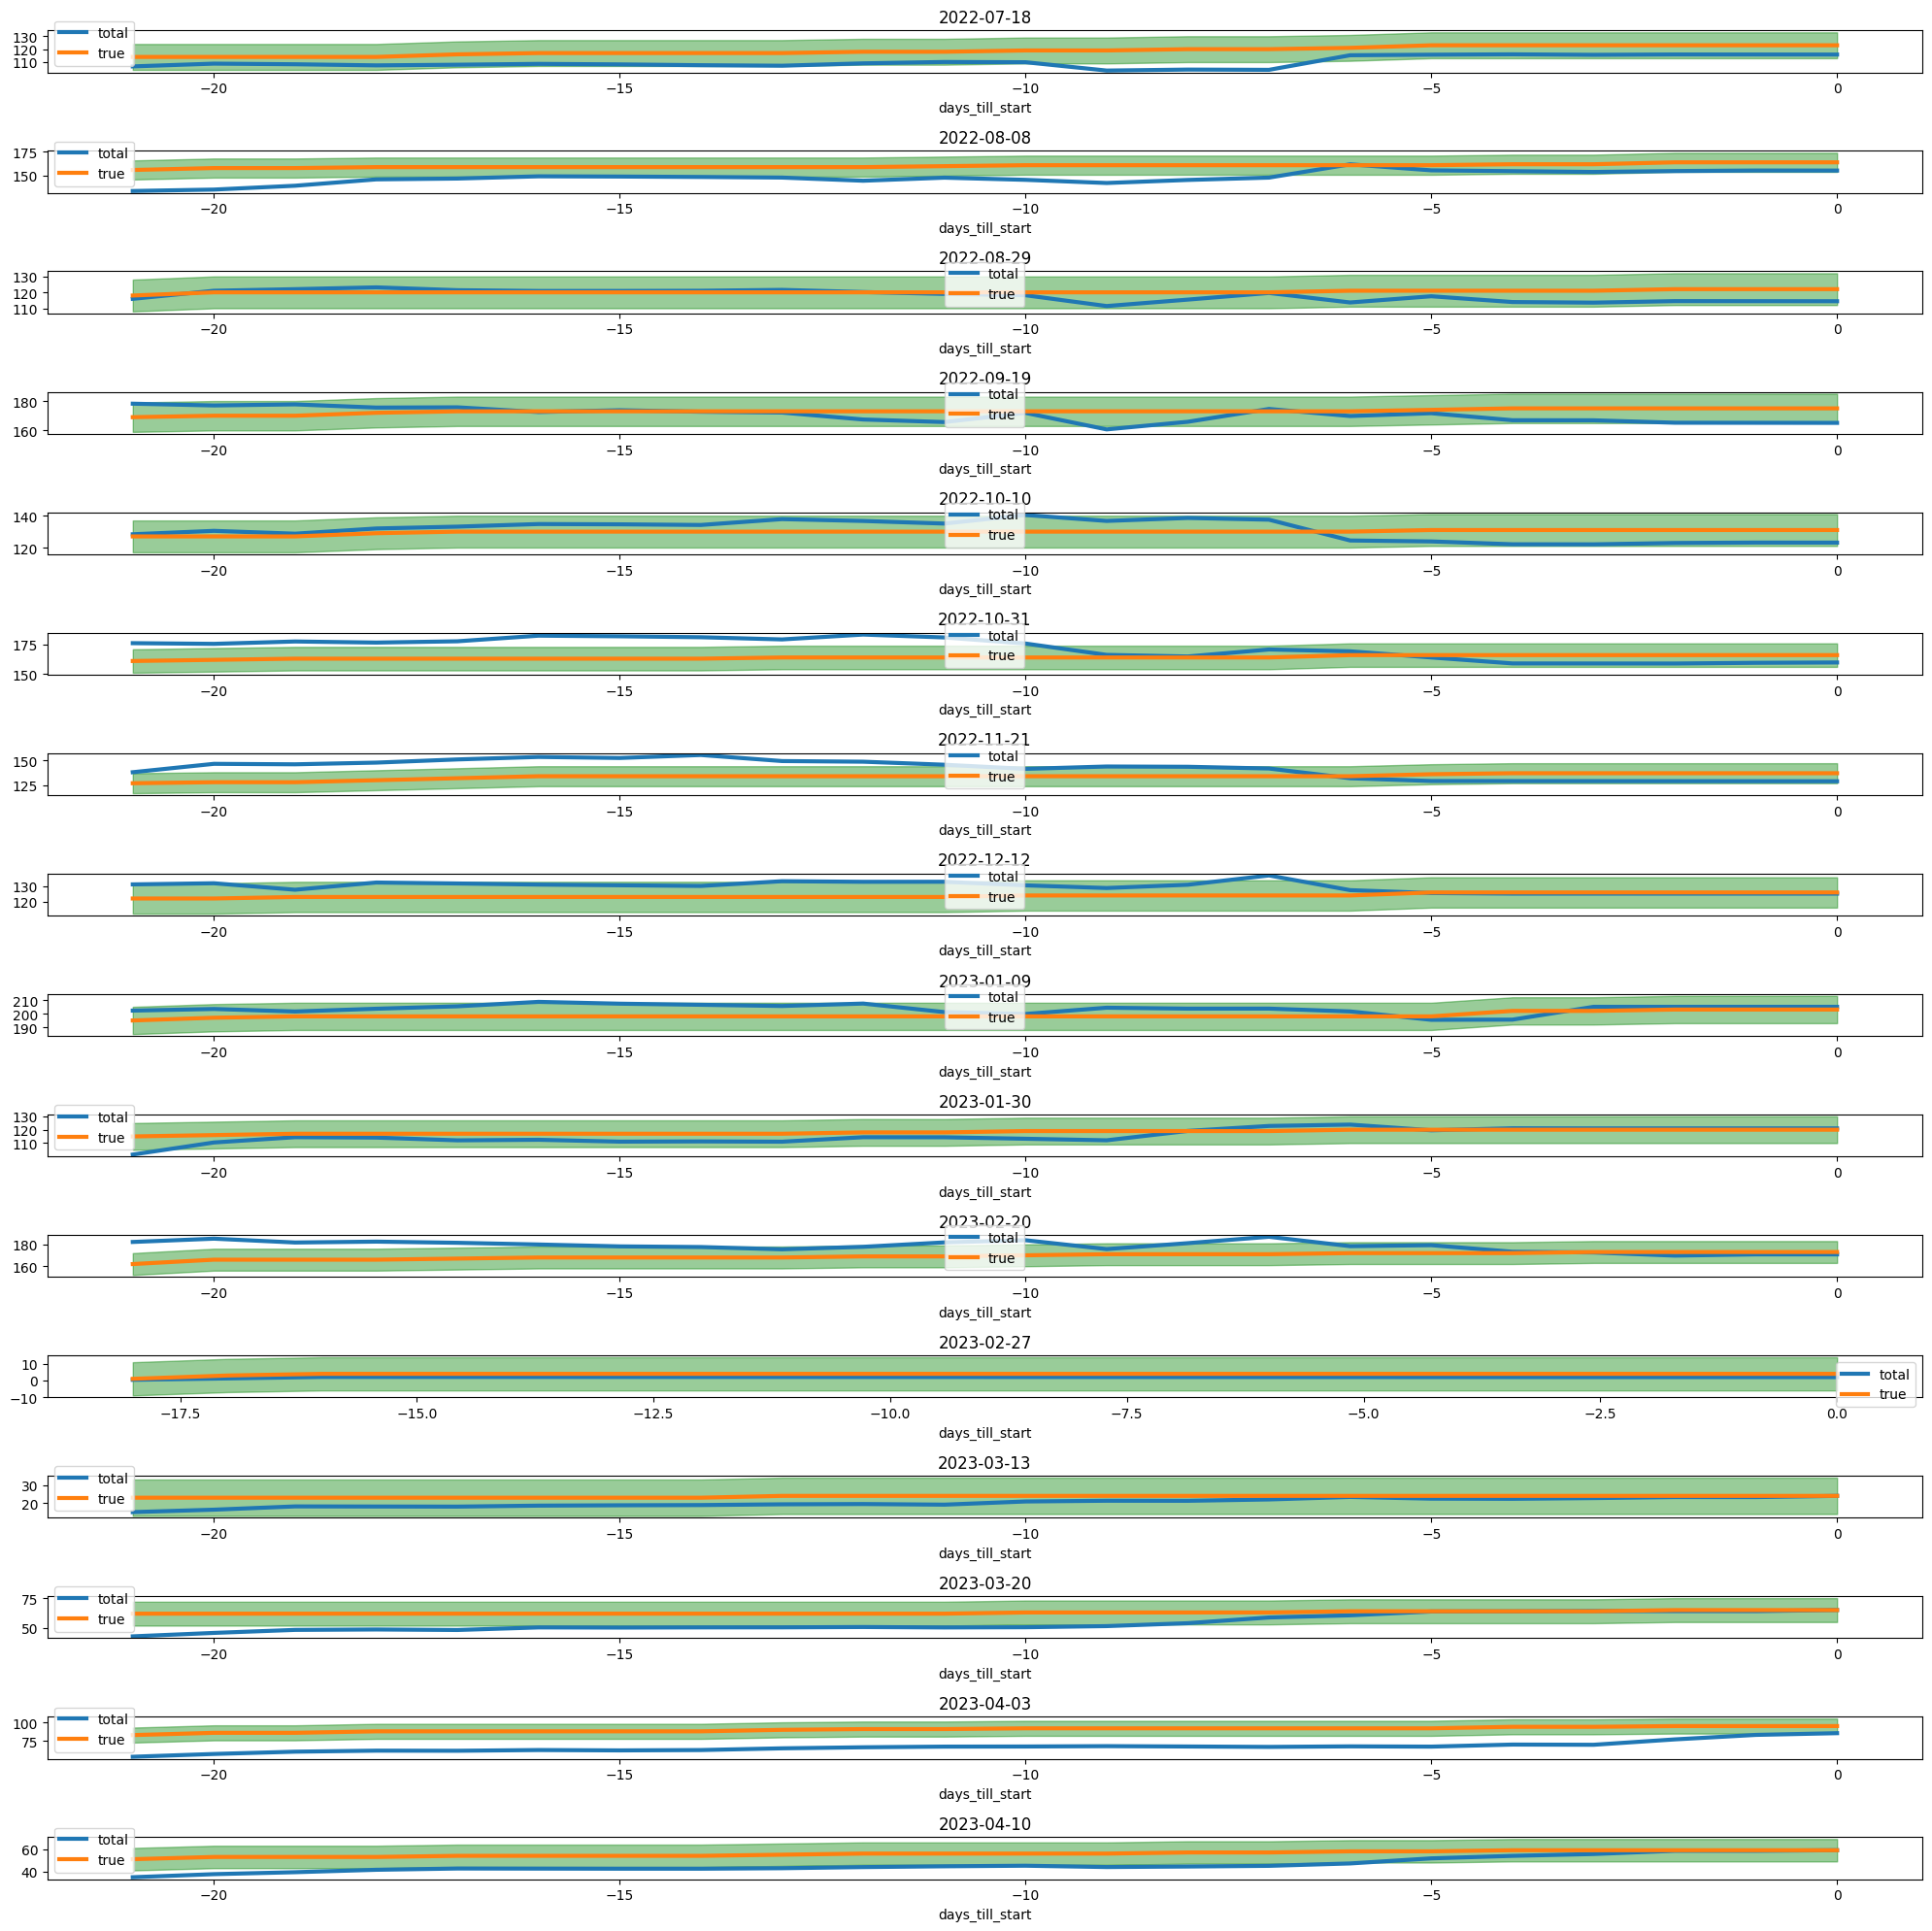

In [17]:
plot_cohorts(df, df.matriculation_count, model)